In [61]:
# Credit risk model

import numpy as np 
import pandas as pd 
import lightgbm as lgb

train = pd.read_excel("../input/Dataset.xlsx", 'train')
test = pd.read_excel("../input/Dataset.xlsx", 'test')
df.head()

,NUM,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,...,F91,F92,F93,F94,F95,F96,F97,F98,F99,F100,F101,F102,F103,F104,F105,F106,F107,F108,F109,F110,F111,F112,F113,F114,F115,F116,F117,F118,F119,F120,F121,F122,F123,F124,F125,F126,F127,F128,F129,TARGET
0,0,0.0,1.0,1.0,199900.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,49725.0,5.0,1.0,120.0,0.0,1.0,0.0,0.0,0.0,0.0,276677.278857,0.0,0.0,1.0,34.0,5.000000,1.0,660000.0,34.0,6.000000,0.0,0.0,0.0,0.0,1.0,1.0,220275.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00000,0.0,0.0,0.0,1.0,0.783327,1.0,3.0,169970.000000,1.000000,1.0,1.0,1.0,0.0,170000.0,2.0,СТЕПЕНЬ,8.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2121.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,17.0,1.0,142918.000000,0.0,3.0,3.0,111.0,5.000000,0.0,125000.0,32.0,876.000000,5.0,0.0,3.0,3.0,19.0,0.0,92879.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,81883.51675,1.0,1.0,1.0,0.0,0.000000,1.0,1.0,424951.475678,2.430397,0.0,0.0,0.0,0.0,30000.0,2.0,СТЕПЕНЬ,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,2121.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,4.0,4.0,276677.278857,0.0,0.0,1.0,5.0,4.430142,0.0,120005.0,23.0,499.315904,0.0,0.0,0.0,0.0,0.0,0.0,-2120.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,81883.51675,0.0,1.0,1.0,0.0,0.000000,1.0,3.0,74129.000000,1.000000,1.0,1.0,0.0,0.0,4.0,6.0,СПЕЦ,5.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,3,2.0,10.0,1.0,1187750.0,130990.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,2121.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,5.0,5.0,276677.278857,0.0,0.0,6.0,6.0,4.430142,0.0,144500.0,21.0,88.000000,1.0,0.0,1.0,0.0,45.0,29.0,62879.0,...,0.0,1.0,3.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,11.0,1.0,12.0,130.00000,7.0,0.0,0.0,0.0,0.000000,1.0,3.0,350916.000000,6.000000,1.0,1.0,1.0,0.0,3000.0,2.0,СТЕПЕНЬ,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0
4,4,0.0,5.0,4.0,318771.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,57831.0,5.0,1.0,179.0,0.0,1.0,0.0,0.0,6.0,6.0,156218.000000,0.0,1.0,6.0,10.0,4.430142,0.0,125000.0,24.0,32.000000,0.0,0.0,0.0,0.0,1.0,7.0,27169.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00000,0.0,0.0,0.0,1.0,1.000000,1.0,2.0,303138.000000,5.000000,1.0,1.0,1.0,0.0,40000.0,6.0,СТЕПЕНЬ,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [62]:
# Features that contain missing values
train.isnull().sum()[train.isnull().sum()>0]

F12     5163
F15    15629
F75    13201
dtype: int64

In [63]:
train.set_index('NUM', inplace=True)
a = train.fillna(-999)

In [64]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['F120'])
list(le.classes_)

['ВЫСШ', 'НЕОК ВЫСШ', 'НЕТ', 'ПРОФИЛЬ', 'СПЕЦ', 'СРЕДН', 'СТЕПЕНЬ', 'ШКОЛ']

In [65]:
a['F120'] = le.transform(a['F120'])
a['F120'].head()

NUM
0    6
1    6
2    4
3    6
4    6
Name: F120, dtype: int64

In [66]:
target = 'TARGET'
y = a['TARGET'].values

inputs = list(set(a.columns) - set([target]))  
cat_vars = ['F120']

In [67]:
# a = a.sample(30000)

# Features "l2" normalization 
from sklearn.preprocessing import normalize

b = normalize(a[inputs], 'l2') 

c = pd.DataFrame(b, index=a.index, columns = a[inputs].columns)
c = pd.concat([c, a.TARGET], axis=1)

In [68]:
from sklearn.model_selection import train_test_split
train_df, val_df, y_train, y_val = train_test_split(c, y, train_size=.8, shuffle=False, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2022: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# **Logistic Regression**

In [69]:
from sklearn.model_selection import cross_val_score
log_reg = LogisticRegression()
scores = cross_val_score(log_reg, c[inputs], y, cv=5, scoring='roc_auc')
print(scores)
print(scores.mean())

[0.79780162 0.79950206 0.80407266 0.7902729  0.79117819]
0.7965654882607814


Optimal number of features : 22


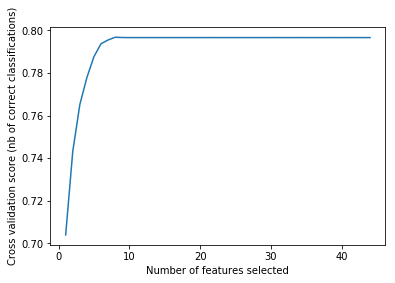

In [70]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=log_reg, step=3, cv=StratifiedKFold(5),
              scoring='roc_auc')
rfecv.fit(c[inputs], y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plotting number of features vs. cross-validation "roc_auc" scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show() 

In [71]:
rfecv.grid_scores_.max()

0.7967215947758554

In [72]:
metrics = 'auc'
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': metrics,
    'learning_rate': .1,
    'num_leaves': 7,
#   'max_depth': 4,
#   'min_child_samples': 100,
#   'max_bin': 100,
#   'subsample': 0.7,
    'subsample_freq': 1,
#   'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'min_split_gain': 0,
    'nthread': 4,
    'verbose': 1,
    'scale_pos_weight': 1.2
}

num_boost_round=20

xgtrain = lgb.Dataset(train_df[inputs].values, label=y_train,
              feature_name=inputs,
              categorical_feature=cat_vars)


xgvalid = lgb.Dataset(val_df[inputs].values, label=y_val,
              feature_name=inputs,
              categorical_feature=cat_vars)
# gc.collect()

evals_results = {}

model = lgb.train(lgb_params,
          xgtrain,
          valid_sets= [xgvalid],
          valid_names=['valid'],
          evals_result=evals_results,
          num_boost_round=num_boost_round,
#         early_stopping_rounds=early_stopping_rounds,
          verbose_eval=1,
          feval=None)
n_estimators = model.best_iteration

print('\nModel Info:')
print('n_estimators:', n_estimators)
print(metrics+':', evals_results['valid'][metrics][n_estimators-1])

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid's auc: 0.798759
[2]	valid's auc: 0.830678
[3]	valid's auc: 0.839249
[4]	valid's auc: 0.841321
[5]	valid's auc: 0.845308
[6]	valid's auc: 0.853738
[7]	valid's auc: 0.856554
[8]	valid's auc: 0.858112
[9]	valid's auc: 0.86158
[10]	valid's auc: 0.863437
[11]	valid's auc: 0.865884
[12]	valid's auc: 0.867311
[13]	valid's auc: 0.868873
[14]	valid's auc: 0.870275
[15]	valid's auc: 0.873555
[16]	valid's auc: 0.875952
[17]	valid's auc: 0.876943
[18]	valid's auc: 0.878553
[19]	valid's auc: 0.87939
[20]	valid's auc: 0.881029

Model Info:
n_estimators: 0
auc: 0.8810286441044967


In [73]:
train = lgb.Dataset(c[inputs].values, label=y,
      feature_name=inputs)
num_round = 20
lgb.cv(lgb_params, train,  num_round, nfold=10)


{'auc-mean': [0.8049839485462437,
  0.8223562625159735,
  0.8370466049936229,
  0.8449138308760922,
  0.8503137244921002,
  0.8552852236266786,
  0.8586561852658235,
  0.8614752474407166,
  0.8637627256317701,
  0.8659149524144834,
  0.8678680679428548,
  0.8703090998743107,
  0.8720382472678605,
  0.8739136533250802,
  0.8751401668481396,
  0.8767969310086077,
  0.8784234579399051,
  0.8798111249225256,
  0.8811849950463312,
  0.8826762620353458],
 'auc-stdv': [0.009156167174831838,
  0.007924605535125097,
  0.006701714843991516,
  0.007121081094232001,
  0.005711660936064556,
  0.006669047624615052,
  0.006929785653607069,
  0.006110039323941873,
  0.006176978404243719,
  0.005873293336322324,
  0.005696641200249378,
  0.005319566886423731,
  0.005191953539693271,
  0.005108286756680682,
  0.005117438638242425,
  0.005114425385092603,
  0.005409628331733586,
  0.0050300218431593114,
  0.005094844120810012,
  0.005003941079993406]}

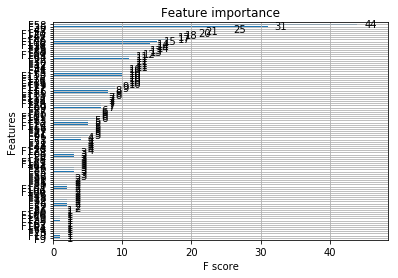

In [74]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(c[inputs], y)
# plot feature importance
plot_importance(model)
pyplot.show()

# print(model.feature_importances_)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# k_range = list(range(1, 20))
# scores = []
# for k in k_range:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(train_df[inputs], y_train)
#     y_pred = knn.predict(val_df[inputs])
#     scores.append(roc_auc_score(y_val, y_pred))
    
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.plot(k_range, scores)
# plt.xlabel('Value of K for KNN')
# plt.ylabel('Testing Accuracy')